In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
base_path = '/media/anant/data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
# Print all unique tags
from itertools import chain
labels_list = list(chain.from_iterable([tags.split(" ") for tags in train_df['tags'].values]))
labels_set = set(labels_list)
print("There is {} unique labels including {}".format(len(labels_set), labels_set))

There is 17 unique labels including {'conventional_mine', 'road', 'habitation', 'primary', 'cloudy', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'blooming', 'agriculture', 'water', 'bare_ground', 'blow_down', 'slash_burn', 'clear', 'haze'}


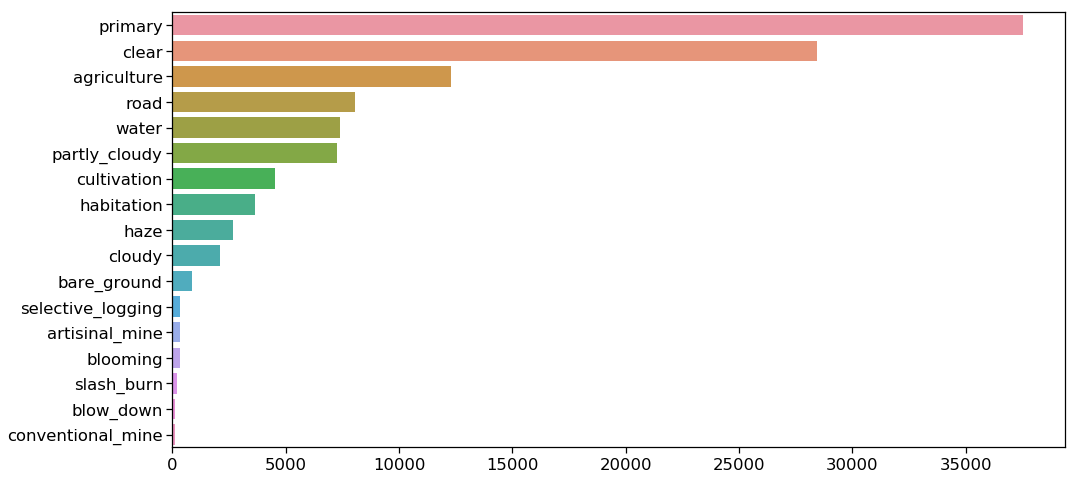

In [5]:
labels_s = pd.Series(labels_list).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [42]:
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [44]:
index = ['conventional_mine', 'road', 'habitation', 'primary', 'cloudy', 'cultivation', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'blooming', 'agriculture', 'water', 'bare_ground', 'blow_down', 'slash_burn', 'clear', 'haze']
labels_s.reindex(index)
weights = labels_s.values/labels_s.values.sum()
print(weights, labels_s.index)

[0.32261477 0.24450885 0.10590997 0.06941124 0.06373519 0.06244517
 0.03910456 0.03147629 0.02319441 0.01796557 0.00741327 0.00292403
 0.00291543 0.00285523 0.00179742 0.00086861 0.00086001] Index(['primary', 'clear', 'agriculture', 'road', 'water', 'partly_cloudy',
       'cultivation', 'habitation', 'haze', 'cloudy', 'bare_ground',
       'selective_logging', 'artisinal_mine', 'blooming', 'slash_burn',
       'blow_down', 'conventional_mine'],
      dtype='object')


In [45]:
print(labels_s)

primary              37513
clear                28431
agriculture          12315
road                  8071
water                 7411
partly_cloudy         7261
cultivation           4547
habitation            3660
haze                  2697
cloudy                2089
bare_ground            862
selective_logging      340
artisinal_mine         339
blooming               332
slash_burn             209
blow_down              101
conventional_mine      100
dtype: int64


In [47]:
reindexed = labels_s.reindex(index)

In [53]:
print(reindexed)
weights = 10*reindexed.values/reindexed.values.sum()
print(weights)

conventional_mine      100
road                  8071
habitation            3660
primary              37513
cloudy                2089
cultivation           4547
partly_cloudy         7261
artisinal_mine         339
selective_logging      340
blooming               332
agriculture          12315
water                 7411
bare_ground            862
blow_down              101
slash_burn             209
clear                28431
haze                  2697
dtype: int64
[0.00860008 0.69411239 0.3147629  3.22614768 0.17965565 0.3910456
 0.62445174 0.02915427 0.02924027 0.02855226 1.05909974 0.63735186
 0.07413268 0.00868608 0.01797417 2.44508849 0.23194413]


In [ ]:
for ival in index

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, fbeta_score
from tqdm import tqdm_notebook, tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.models as models

In [7]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
print(len(image_list))

40479


In [8]:
class AmazonDataset(Dataset):
    def __init__(self, base_folder, csv_file, folder_name, transform=None):
        self.csv_file = csv_file
        self.labels_df = pd.read_csv(base_path+csv_file)
        self.base_folder = base_folder
        self.image_list = [f for f in glob.glob(base_path+folder_name+'/*.jpg')]
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.labels = self.mlb.fit_transform(self.labels_df['tags'].str.split()).astype(np.float32)
        
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index])
        image = image.convert('RGB')
        # image = cv2.imread(self.image_list[index])
        
        label = torch.from_numpy(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label


In [9]:
class ResFeatureExtractor(nn.Module):
    def __init__(self, n_classes=14, pretrained_model=models.resnet50, debug=False):
        super(ResFeatureExtractor, self).__init__()

        self.n_classes = n_classes
        
        pretrained_model = pretrained_model(pretrained=True)
        last_fc_in_features = pretrained_model.fc.in_features
        pretrained_model = nn.Sequential(*list(pretrained_model.children())[:-1])
        for parameter in pretrained_model.parameters():
            parameter.requires_grad = True

        self.pretrained = pretrained_model
        self.classifier = nn.Sequential(nn.Linear(last_fc_in_features, self.n_classes))
        self.debug = debug
        if self.debug:
            print(last_fc_in_features)


    def forward(self, x):
        if self.debug:
            print('x = ', x.shape)
        x = self.pretrained(x)
        if self.debug:
            print('x = ', x.shape)
        x = x.view(x.size(0), -1)
        if self.debug:
            print('x = ', x.shape)
        x = self.classifier(x)
        if self.debug:
            print('x = ', x.shape)
        return x

In [10]:
class BaseNet(nn.Module):
    def __init__(self):
        super(BaseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(2304, 256)
        self.fc2 = nn.Linear(256, 17)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1) # Flatten layer
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [11]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform_augmented = transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.ColorJitter(brightness=0.5, contrast=0.2,
                                                                       saturation=0.4),
                                                transforms.RandomVerticalFlip(),
                                                transforms.ToTensor(),
                                                normalize])
valid_transform_augmented = transforms.Compose([transforms.RandomResizedCrop(224),
                                                transforms.ToTensor(),
                                                normalize])

In [12]:
train_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', transform=train_transform_augmented)
valid_dataset = AmazonDataset(base_path, 'train_v2.csv', 'train-jpg', transform=valid_transform_augmented)

BATCH_SIZE = 32
random_seed = 42
shuffle_dataset = True
validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler, num_workers=8)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler, num_workers=8)


print(len(train_loader), len(validation_loader))
image, label = next(iter(train_loader))
print(image.shape, label.shape)
n_classes = label.shape[1]
del(image, label)

1012 253
torch.Size([32, 3, 224, 224]) torch.Size([32, 17])


In [13]:
model = ResFeatureExtractor(n_classes=n_classes, pretrained_model=models.resnet50, debug=True)

image, label = next(iter(train_loader))
out = model(image)
print(out.shape)
del(image, label)

2048
x =  torch.Size([32, 3, 224, 224])
x =  torch.Size([32, 2048, 1, 1])
x =  torch.Size([32, 2048])
x =  torch.Size([32, 17])
torch.Size([32, 17])


In [14]:
print(out.detach().numpy()[0])

[-0.09615045  0.49970987 -0.35882095  0.41309944  0.05652883  0.65800065
 -0.67261463 -0.26207468 -0.35479236  0.3955221   0.13608868  0.0586225
  0.09288432  0.19944008 -0.29015264 -0.46678665 -0.4384925 ]


In [ ]:
# from scipy.optimize import fmin_l_bfgs_b, basinhopping

# def best_f2_score(true_labels, predictions):

#     def f_neg(threshold):
#         ## Scipy tries to minimize the function so we must get its inverse
#         return - fbeta_score(true_labels, predictions > threshold, beta=2, average='samples')

#     # Initialization of best threshold search
#     thr_0 = [0.20] * 17
#     constraints = [(0.,1.)] * 17
#     def bounds(**kwargs):
#         x = kwargs["x_new"]
#         tmax = bool(np.all(x <= 1))
#         tmin = bool(np.all(x >= 0)) 
#         return tmax and tmin
    
#     # Search using L-BFGS-B, the epsilon step must be big otherwise there is no gradient
#     minimizer_kwargs = {"method": "L-BFGS-B",
#                         "bounds":constraints,
#                         "options":{
#                             "eps": 0.05
#                             }
#                        }
    
#     # We combine L-BFGS-B with Basinhopping for stochastic search with random steps
#     logger.info("===> Searching optimal threshold for each label")
#     start_time = timer()
    
#     opt_output = basinhopping(f_neg, thr_0,
#                                 stepsize = 0.1,
#                                 minimizer_kwargs=minimizer_kwargs,
#                                 niter=10,
#                                 accept_test=bounds)
    
#     end_time = timer()
#     logger.info("===> Optimal threshold for each label:\n{}".format(opt_output.x))
#     logger.info("Threshold found in: %s seconds" % (end_time - start_time))
    
#     score = - opt_output.fun
#     return score, opt_output.x

EPOCH: 0: ITERATION: 0 / 1012 : LOSS: 0.4125139117240906     EVALUATION: [0.09525921631589708, 0.3369630853281817]
EPOCH: 0: ITERATION: 200 / 1012 : LOSS: 0.1000841036438942     EVALUATION: [0.02155471551176823, 0.6955190812230422]
EPOCH: 0: ITERATION: 400 / 1012 : LOSS: 0.05413563549518585     EVALUATION: [0.0208477655999922, 0.7248324520047396]
EPOCH: 0: ITERATION: 600 / 1012 : LOSS: 0.06434909254312515     EVALUATION: [0.020682179177614304, 0.7452830658106102]
EPOCH: 0: ITERATION: 800 / 1012 : LOSS: 0.08202922344207764     EVALUATION: [0.020595877596983326, 0.7510053260452927]
EPOCH: 0: ITERATION: 1000 / 1012 : LOSS: 0.10050054639577866     EVALUATION: [0.02056501311408319, 0.7520663037866832]
EPOCH: 1: ITERATION: 0 / 1012 : LOSS: 0.09040771424770355     EVALUATION: [0.020523855676175106, 0.7522078434469889]
EPOCH: 1: ITERATION: 200 / 1012 : LOSS: 0.08383125066757202     EVALUATION: [0.020546959996547386, 0.7523203932865853]
EPOCH: 1: ITERATION: 400 / 1012 : LOSS: 0.0652900338172912

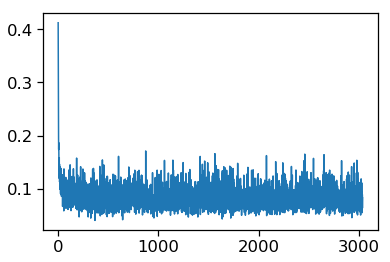

In [54]:
GPU = 'cuda:1'

num_epochs = 3
learning_rate = 0.01

model = ResFeatureExtractor(n_classes=n_classes, pretrained_model=models.resnet50, debug=False)

if torch.cuda.is_available():
    model.to(torch.device(GPU))
    
    

# criterion = nn.BCELoss()
# criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MultiLabelSoftMarginLoss()
# criterion = torch.nn.MultiLabelSoftMarginLoss(weight = torch.Tensor([1,  4,  2,  1,
#                                                                      1,  3,  3,  3,
#                                                                      4,  4,  1,  2,
#                                                                      1,  1,  3,  4,  1])).to(torch.device(GPU))

criterion = torch.nn.MultiLabelSoftMarginLoss(weight = torch.Tensor(weights)).to(torch.device(GPU))


optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


loss_list = []

for epoch in range(num_epochs):
    for iteration, (images, labels) in enumerate(train_loader):
    
        model.train()
        if torch.cuda.is_available():
            images = images.to(torch.device(GPU))
            labels = labels.to(torch.device(GPU))
        
        optimizer.zero_grad()
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            loss_list.append(loss.cpu().data)
            
            if iteration%200 == 0:
                eval_loss = 0
                true_labels = []
                predictions = []
                model.eval()
                for eval_iteration, (X, y) in enumerate(validation_loader):
                    if torch.cuda.is_available():
                        X = X.to(torch.device(GPU))
                        y = y.to(torch.device(GPU))

                    y_pred = model(X)

                    if torch.cuda.is_available():
                        eval_loss += criterion(y_pred, y).cpu().detach().numpy()
                        true_labels.extend(y.detach().cpu().numpy().tolist())
                        predictions.extend(torch.sigmoid(y_pred.detach()).cpu().numpy().tolist())
                    else:
                        eval_loss += criterion(y_pred, y).detach().numpy()
                        true_labels.extend(y.detach().numpy().tolist())
                        predictions.extend(torch.sigmoid(y_pred.detach()).numpy().tolist())
                        
                

                true_labels = np.vstack(true_labels)
                predictions = np.vstack(predictions)
                
                score = fbeta_score(true_labels, predictions>0.5, beta=0.5, average='samples')
#                 accuracy = accuracy_score(gt, preds)
#                 print("EPOCH: {0}: ITERATION: {1} / {2} : LOSS: {3}     EVALUATION: [{4} {5} {6}]".format(epoch, iteration, len(train_loader),
#                                                                                                       loss.cpu().data, eval_loss/total, 
#                                                                                                       score, accuracy))
                print("EPOCH: {0}: ITERATION: {1} / {2} : LOSS: {3}     EVALUATION: [{4}, {5}]".format(epoch, iteration, len(train_loader),
                                                                                                      loss.cpu().data, eval_loss/len(train_loader), score))
            
            
plt.plot(np.arange(0,len(loss_list)), np.array(loss_list))



In [58]:
choice = 5000
print(true_labels[choice])
print((predictions[choice]>0.5)+0.)

[1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [27]:
predictions.shape

(8095, 17)

In [28]:
validation_loader_plot = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                                     sampler=valid_sampler, num_workers=12)

model.eval()
with torch.no_grad():
    loss_list.append(loss.cpu().data)
    gt_preds = []

    total = 0
    for (X, y) in tqdm(validation_loader_plot):
#     for iteration, (X, y) in enumerate(validation_loader_plot):
        if torch.cuda.is_available():
            X = X.to(torch.device('cuda:1'))
            y = y.to(torch.device('cuda:1'))

        y_pred = model(X)

        gt_preds.append((y.cpu().numpy(), y_pred.cpu().numpy()))
#         if iteration%500 == 0:
#             print(iteration)
        # total += y.size(0)

        # if torch.cuda.is_available():
        #     eval_loss += criterion(y_pred, y).cpu().data
        # else:
        #     eval_loss += criterion(y_pred, y).data

    # print("{0}: {1} / {2} : {3} {4}".format(epoch, iteration, len(train_loader), 
    #                                         loss.cpu().data, eval_loss.cpu().data/total))

print(len(gt_preds))



100%|██████████| 8095/8095 [00:17<00:00, 469.38it/s]

8095


[[0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] [[-0. -3. -2. -3. -3.  0. -2. -3. -1. -1. -1. -1.  1. -1. -3. -3. -1.]]


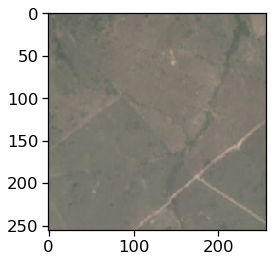

In [29]:
for index, (image, label) in enumerate(validation_loader_plot):
    image = np.moveaxis(np.squeeze(image.numpy()), (0,1,2), (2,0,1))
    plt.imshow(image)
    print(gt_preds[index][0], np.round(gt_preds[index][1]))
    break